## Projet Machine learning et contrôle stochastique

Etudiants : 

AKIL Mohamed-Aymane

LAMSAOUB Mohamed

Dans ce notebook, nous explorons et expérimentons les méthodes numériques présentées dans l'article **Randomized Optimal Stopping Problem in Continuous Time and Reinforcement Learning Algorithm**.

L'objectif est d'implémenter et d'illustrer l'approche proposée dans cet article, qui consiste à reformuler un problème d'arrêt optimal en un problème de contrôle optimal. Nous résolvons ensuite ce dernier à l'aide de différentes techniques, notamment des méthodes basées sur les équations aux dérivées partielles (EDP) ainsi que des approches inspirées de l'apprentissage par renforcement, comme l'algorithme de policy iteration.
 


In [87]:
import solvers
from solvers import *
import numpy as np 
import matplotlib.pyplot as plt
import importlib
importlib.reload(solvers)
%matplotlib inline

### 1. Résolution numérique de l'EDP par différences finies (Backward) :

Dans cette partie dans l'article (chapitre 3) on considère le problème d'arret optimal afin de pricer une option américain. 

Ce problème d'arret optimal est convertie en un problème de controle avec l'equation HJB (3.2) : 

$\partial_t V^\lambda + \mathcal{L}_S V^\lambda + \lambda \exp\left(-\frac{V^\lambda - g}{\lambda}\right) = 0, \quad V^\lambda(S,T) = g(S).$


**Théorème 3.7 :**
La solution de cette EDP 3.2 converge vers le prix standard d'une option américain quand le terme de régularisation $\lambda$ tend vers zero


$u^\lambda$ --> $u^*$ qd $\lambda->0$

#### Illustration du Théorème 3.7 :

On cherche la solution de l'EDP 3.2 $u^\lambda$ en utilisant la discrétisation de l'EDP pour avoir shema d'euler implicite combinée avec la méthode de newtone. (le solver est implimenté dans la fonction pde_solver_regularization dans le fichier solvers.py)


En ce qui concerne le prix du l'option amércain standard $u^*$ on peut le calculer en utilisant la méthode de pénalité **Penalty Method** référé par l'article dans [9]

**Bref explication du Penalty method** :

On considère la valeur de l'option $V(S,t)$ satisfaisant l'inéquation variationnelle :
\begin{equation}
    \max \left( \partial_t V + \mathcal{L}_S V + f, V - g \right) = 0,
\end{equation}

La méthode de pénalisation approxime cette inéquation par une EDP modifiée :
\begin{equation}
    \partial_t V^\lambda + \mathcal{L}_S V^\lambda - r V^\lambda - \lambda \max(0, g(S) - V^\lambda) = 0,
\end{equation}
Ici, $\lambda > 0$ est un paramètre de pénalisation qui impose progressivement la contrainte $V \geq g$ lorsque $\lambda \to 0$. La solution $V^\lambda$ converge alors vers la solution de l'option américaine.


On va utiliser le meme shéma numérique pour résoudre les deux EDP

In [88]:
# parameters : 

r = 0.05        # Risk-free rate
sigma = 0.4     # Volatility
K = 1.0         # Strike price
T = 1.0         # Expiry time
lambda_ = 0.005 # Temperature constant
Nx = 100        # Number of space steps
Nt = 100        # Number of time steps
max_iter = 100
tol = 1e-6
# Space discretization
x_min, x_max = -1, 1  # Domain fo

In [89]:
x = np.linspace(x_min, x_max, Nx+1)
U = pde_solver_regularization(r,sigma,K,T,lambda_,Nx,Nt,x_min,x_max,max_iter)

In [90]:
lambda_values = [0.1,0.05,0.01,0.001]
U_values = np.zeros((len(lambda_values),len(x)))

for k,lda in enumerate(lambda_values) : 

    U_values[k] = pde_solver_regularization(r,sigma,K,T,lda,Nx,Nt,x_min,x_max,max_iter)


U_american_price = penalty_pde_solver(r,sigma,K,T,lambda_,Nx,Nt,x_min,x_max)

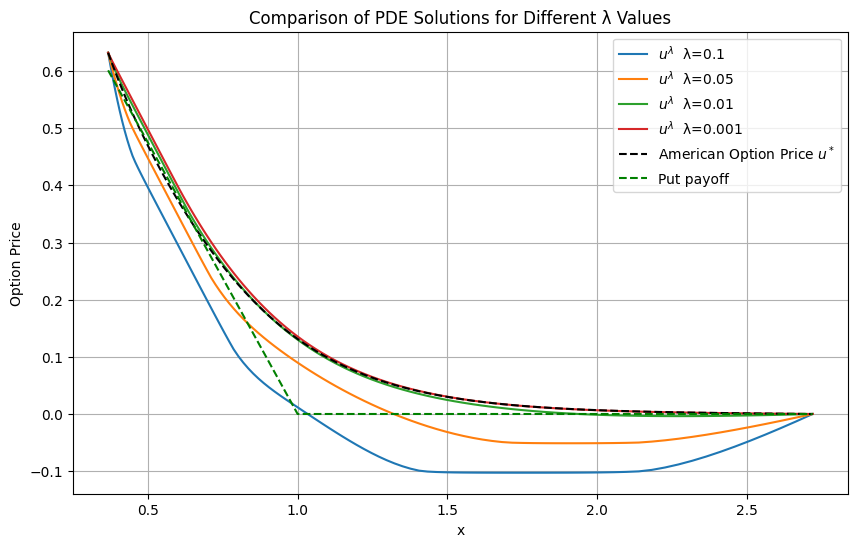

In [91]:
# Plot results
plt.figure(figsize=(10, 6))
for k, lda in enumerate(lambda_values):
    plt.plot(np.exp(x), U_values[k], label=fr'$u^λ$  λ={lda}')

# Plot American option price
plt.plot(np.exp(x), U_american_price, 'k--', label='American Option Price $u^*$')
plt.plot(np.exp(x),np.exp(-r*T)*np.maximum(K-np.exp(x),0), label = 'Put payoff', linestyle='dashed',color = 'Green')

plt.xlabel('x')
plt.ylabel('Option Price')
plt.title('Comparison of PDE Solutions for Different λ Values')
plt.legend()
plt.savefig("Algo1.png")
plt.grid()
plt.show()



### 2. Algorithme d'itération de politique $\textit{(Policy iteration)}$ :



En apprentissage par renforcement, une méthode pour apprendre la stratégie optimale est l'itération de politique, dans laquelle la stratégie optimale est approximée par une mise à jour itérative. Plus précisément, étant donnée une stratégie de retour $\pi^n(x,t)$, la fonction de valeur correspondante $u^n(x,t)$ satisfait



\begin{equation}
    \partial_t u^n + \mathcal{L}_x u^n + H(x, \pi^n(x,t), u^n) = 0, \quad u^n(x,T) = h(x),
\end{equation}


où l'Hamiltonien $H$ est défini comme

\begin{equation}
    H(x, \pi, u) = (h(x) - u)\pi + \lambda R(\pi).
\end{equation}

Ayant une fonction de valeur $u^n$, on peut construire une stratégie de retour $\pi^{n+1}$ comme
$
\begin{equation}
    \pi^{n+1}(x,t) = \arg\max_{\pi \in (0,\infty)} H(x, \pi, u^n(x,t)) = \exp \left( -\frac{u^n(x,t) - h(x)}{\lambda} \right).
\end{equation}
$



**Theorème 3.3:**

Soit une estimation initiale $u^0 \in C_b(\mathbb{R})$ pour la fonction de valeur optimale. 
La suite $\{u^n, \pi^n\}_{n=1,2,\dots}$ est définie itérativement selon \eqref{eq:policy_update} et \eqref{eq:policy_iteration}. 
Alors, nous avons 



$u^\lambda \geq u^{n+1} \geq u^n, \quad \text{pour } n = 1, 2, \dots$

On s'attend à ce que les fonctions de valeur $\{u^n\}$ convergent vers la fonction de valeur optimale $u^\lambda$. 
C'est effectivement le cas. De plus, nous pouvons donner une estimation du taux de convergence des fonctions de valeur.

**Théorème 3.4 :**



Soit $M := \|(h - u^1)^+\|_{\infty}$. Il existe une constante $C$ indépendante de $\lambda$ telle que :
$\| u^{n+1} - u^\lambda \|_{\infty} \leq C^n \frac{T^n}{n!} \exp \left( n \frac{M}{\lambda} + rT \right) (M + K + \lambda T).$


### Illustration des theorèmes : 

Implementation du **Policy iteration algorithm** sur policy_iteration_solver.py

In [92]:
lambda_ = 0.001
max_iter = 2000
x,U = policy_iteration_solver(r,sigma,K,T,lambda_,Nx+1,Nt,x_min,x_max,max_iter,tol)
u_lambda = pde_solver_regularization(r,sigma,K,T,lambda_,Nx,Nt,x_min,x_max,max_iter)

Policy Iteration 1
Policy Iteration 2
Policy Iteration 3
Policy Iteration 4
Policy Iteration 5


c:\Users\moham\.conda\envs\torch\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


Policy Iteration 6
Policy Iteration 7
Policy Iteration 8
Policy Iteration 9
Policy Iteration 10
Policy Iteration 11
Policy Iteration 12
Policy Iteration 13
Policy Iteration 14
Policy Iteration 15
Policy Iteration 16
Policy Iteration 17
Policy Iteration 18
Policy Iteration 19
Policy Iteration 20
Policy Iteration 21
Policy Iteration 22
Policy Iteration 23
Policy Iteration 24
Policy Iteration 25
Policy Iteration 26
Policy Iteration 27
Policy Iteration 28
Policy Iteration 29
Policy Iteration 30
Policy Iteration 31
Policy Iteration 32
Policy Iteration 33
Policy Iteration 34
Policy Iteration 35
Policy Iteration 36
Policy Iteration 37
Policy Iteration 38
Policy Iteration 39
Policy Iteration 40
Policy Iteration 41
Policy Iteration 42
Policy Iteration 43
Policy Iteration 44
Policy Iteration 45
Policy Iteration 46
Policy Iteration 47
Policy Iteration 48
Policy Iteration 49
Policy Iteration 50
Policy Iteration 51
Policy Iteration 52
Policy Iteration 53
Policy Iteration 54
Policy Iteration 55
Poli

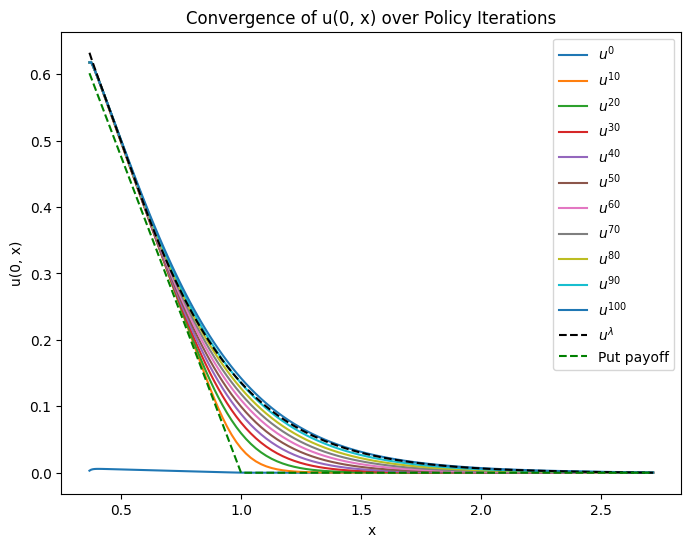

In [93]:
plt.figure(figsize=(8, 6))
for i, u_0 in enumerate(U):
    if i % 10 == 0:
        plt.plot(np.exp(x), u_0, label=fr"$u^{ {i} }$")


plt.plot(np.exp(x), u_lambda, 'k--', label='$u^{\lambda}$')
plt.plot(np.exp(x),np.exp(-r*T)*np.maximum(K-np.exp(x),0), label = 'Put payoff', linestyle='dashed',color = 'Green')
plt.legend()
plt.xlabel("x")
plt.ylabel("u(0, x)")
plt.title("Convergence of u(0, x) over Policy Iterations")
plt.savefig('Algo2.png')
plt.show()

### 3. Résolution de l'équation HJB par apprentissage profond et algorithme d'apprentissage par renforcement



#### L'objectif de cette section est d'implémenter et d'expérimenter l'algorithme 4.1 présenté dans l'article.  

L'algorithme est implémenté dans le fichier *torch_RL.py*.

In [94]:
import torch_RL 
from torch_RL import *
import importlib 
from scipy import stats

importlib.reload(torch_RL)
S_samples = generate_black_scholes_paths(N-1,M).T
n_iteration = 1500


Using cuda device


In [95]:
Phi_functions,optimizers = Phi_NN(K,N)
evaluation = train_evaluate(n_iteration,0.05,Phi_functions,optimizers,S_samples)

1 Iteration ...
Epochs 1 finished !
TOTAL LOSS : 6.410566806793213
2 Iteration ...
Epochs 2 finished !
TOTAL LOSS : 6.88417387008667
3 Iteration ...
Epochs 3 finished !
TOTAL LOSS : 6.3350443840026855
4 Iteration ...
Epochs 4 finished !
TOTAL LOSS : 6.431890964508057
5 Iteration ...
Epochs 5 finished !
TOTAL LOSS : 7.039849758148193
6 Iteration ...
Epochs 6 finished !
TOTAL LOSS : 6.749862194061279
7 Iteration ...
Epochs 7 finished !
TOTAL LOSS : 6.7489213943481445
8 Iteration ...
Epochs 8 finished !
TOTAL LOSS : 6.8357744216918945
9 Iteration ...
Epochs 9 finished !
TOTAL LOSS : 6.748780727386475
10 Iteration ...
Epochs 10 finished !
TOTAL LOSS : 6.921437740325928
11 Iteration ...
Epochs 11 finished !
TOTAL LOSS : 6.974538326263428
12 Iteration ...
Epochs 12 finished !
TOTAL LOSS : 7.006175518035889
13 Iteration ...
Epochs 13 finished !
TOTAL LOSS : 6.7612528800964355
14 Iteration ...
Epochs 14 finished !
TOTAL LOSS : 6.677765846252441
15 Iteration ...
Epochs 15 finished !
TOTAL LOSS 

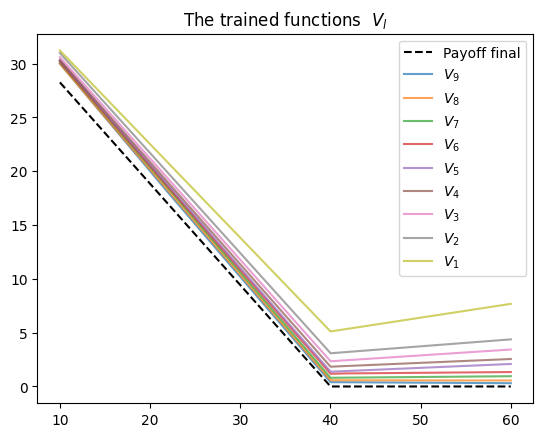

In [96]:
xx = np.linspace(10, 60, 10000).astype(np.float32)

plt.plot(xx, payoff_phi(N, xx), label="Payoff final", color='black', linestyle='dashed')

for l in range(N-2,-1,-1):
    # Plot Continuation Functions (C_n)
    xx_tensor = torch.tensor(xx).reshape(-1, 1).to("cuda" if torch.cuda.is_available() else "cpu")  
    Cn =Phi_functions[l](xx_tensor).detach().cpu().numpy().flatten()  
    plt.plot(xx, Cn, label=fr"$V_{l+1}$", alpha=0.7)
    plt.legend()
plt.title('The trained functions  $V_l$')
plt.savefig('trained_functions.png')

**Remarque :**


On remarque que les fonctions entraînées $V_{l}$  vérifient bien les propriétés d'une fonction de prix, vu qu'elles s'approchent du payoff lorsque l'on s'approche de la maturité.

In [ ]:
# Estimation du prix par Monte carlo en utilisant les fonctions V_l 
S_samples = generate_black_scholes_paths(N-1,2**8).T
price,list_price = calculate_price(Phi_functions,S_samples)


sample = list_price
mean = np.mean(sample)
var = np.var(sample, ddof=1)
alpha = 1 - 0.9 
quantile = stats.norm.ppf(1 - alpha/2)  # fonction quantile 
ci_size = quantile * np.sqrt(var / sample.size)
result = { 'mean': mean, 'var': var, 
            'lower': mean - ci_size, 
            'upper': mean + ci_size }

print(result)

{'mean': 5.209718410185017, 'var': 46.327301498853316, 'lower': 4.509996011780749, 'upper': 5.909440808589285}


**Rq :** 
En évaluant le prix sur de nouvelles trajectoires de Monte Carlo, nous retrouvons une estimation correcte du prix de l'option (environ 5,30), bien que la variance reste élevée.

In [ ]:
S_samples = generate_black_scholes_paths(N-1,M).T
P = {}
n_iteration = 1500
lambda_values = [0.5,0.005]

for lambda_ in lambda_values : 

    Phi_functions,optimizers = Phi_NN(K,N)
    evaluation = train_evaluate(n_iteration,lambda_,Phi_functions,optimizers,S_samples)
    P[lambda_] = evaluation

1 Iteration ...
Epochs 1 finished !
TOTAL LOSS : 6.318230152130127
2 Iteration ...
Epochs 2 finished !
TOTAL LOSS : 6.517955303192139
3 Iteration ...
Epochs 3 finished !
TOTAL LOSS : 6.186376094818115
4 Iteration ...
Epochs 4 finished !
TOTAL LOSS : 6.454659461975098
5 Iteration ...
Epochs 5 finished !
TOTAL LOSS : 6.334532260894775
6 Iteration ...
Epochs 6 finished !
TOTAL LOSS : 6.598947048187256
7 Iteration ...
Epochs 7 finished !
TOTAL LOSS : 6.774224758148193
8 Iteration ...
Epochs 8 finished !
TOTAL LOSS : 6.777122497558594
9 Iteration ...
Epochs 9 finished !
TOTAL LOSS : 6.416633129119873
10 Iteration ...
Epochs 10 finished !
TOTAL LOSS : 6.6262407302856445
11 Iteration ...
Epochs 11 finished !
TOTAL LOSS : 6.552012920379639
12 Iteration ...
Epochs 12 finished !
TOTAL LOSS : 6.736105442047119
13 Iteration ...
Epochs 13 finished !
TOTAL LOSS : 6.682631015777588
14 Iteration ...
Epochs 14 finished !
TOTAL LOSS : 6.53638219833374
15 Iteration ...
Epochs 15 finished !
TOTAL LOSS : 6

Text(0, 0.5, 'Relative error')

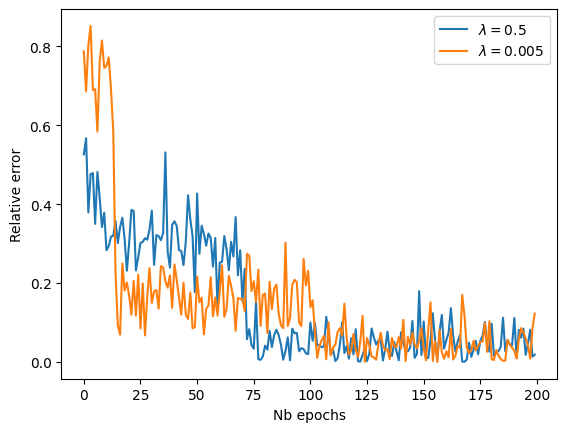

In [103]:
for lambda_ in lambda_values : 


    plt.plot(P[lambda_][:200],label = '$\lambda =$'+str(lambda_))
plt.legend()

plt.xlabel('Nb epochs')
plt.ylabel('Relative error')

**Rq :**


Nous observons que la fonction de prix converge correctement vers la valeur réelle.

De plus, nous avons illustré l'effet du paramètre de régularisation $\lambda$  qui influence le compromis entre vitesse de convergence et biais.